In [155]:
import torch

from transformers.modeling_camembert import CamembertForMaskedLM
from transformers.tokenization_camembert import CamembertTokenizer

In [156]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
model = CamembertForMaskedLM.from_pretrained("camembert-base")

Some weights of CamembertForMaskedLM were not initialized from the model checkpoint at camembert-base and are newly initialized: ['lm_head.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [236]:
masked_input = "Le camembert est <mask>"

In [237]:
input_ids = torch.tensor(tokenizer.encode(masked_input, add_special_tokens=True)).unsqueeze(0)  # Batch size 1
input_ids

tensor([[    5,    54,   730, 25543,   110,    30, 32004,     6]])

In [262]:
logits = model(input_ids)[0]
logits

tensor([[[ 20.7106,  -4.0967,   5.2671,  ...,  -6.2769,  -2.7303,   0.4111],
         [  1.7460,  -4.2540,  14.7513,  ..., -12.5015,  -2.0326,  -0.4934],
         [ -0.2075,  -9.5619,   2.0606,  ..., -22.7009, -11.3049,  -2.6596],
         ...,
         [ -0.6700,  -5.9483,   3.0654,  ..., -11.2913,  -6.0478,  -2.4803],
         [ -1.3376,  -4.8957,   3.2523,  ...,  -8.7402,  -5.2620,  -4.2058],
         [  4.4530,  -5.7768,  22.4035,  ...,  -9.3832,  -5.1804,   1.5240]]],
       grad_fn=<AddBackward0>)

In [232]:
logits[0]

tensor([[[ 20.7106,  -4.0967,   5.2671,  ...,  -6.2769,  -2.7303,   0.4111],
         [  1.7460,  -4.2540,  14.7513,  ..., -12.5015,  -2.0326,  -0.4934],
         [ -0.2075,  -9.5619,   2.0606,  ..., -22.7009, -11.3049,  -2.6596],
         ...,
         [ -0.6700,  -5.9483,   3.0654,  ..., -11.2913,  -6.0478,  -2.4803],
         [ -1.3376,  -4.8957,   3.2523,  ...,  -8.7402,  -5.2620,  -4.2058],
         [  4.4530,  -5.7768,  22.4035,  ...,  -9.3832,  -5.1804,   1.5240]]],
       grad_fn=<AddBackward0>)

In [240]:
input_ids.squeeze() == tokenizer.mask_token_id

tensor([False, False, False, False, False, False,  True, False])

In [241]:
masked_index = (input_ids.squeeze() == tokenizer.mask_token_id).nonzero().item()
print(masked_index)

6


In [263]:
logits = logits[0, masked_index, :]
logits

tensor([-1.3376, -4.8957,  3.2523,  ..., -8.7402, -5.2620, -4.2058],
       grad_fn=<SliceBackward>)

In [271]:
prob = logits.softmax(dim=0)
prob

tensor([2.5646e-07, 7.3071e-09, 2.5259e-05,  ..., 1.5636e-10, 5.0662e-09,
        1.4568e-08], grad_fn=<SoftmaxBackward>)

In [275]:
values, indices = prob.topk(k=5, dim=0)
print(values)
print(indices)

tensor([0.3287, 0.1830, 0.1183, 0.1059, 0.0467], grad_fn=<TopkBackward>)
tensor([ 23, 186,  28, 807,  16])


In [287]:
topk_predicted_token_bpe = " ".join(
        [tokenizer.convert_ids_to_tokens(indices[i].item()) for i in range(len(indices))]
    )
topk_predicted_token_bpe

'▁un ▁... ▁une ▁[...] ▁le'

In [293]:
indices[0].item()

23

topk_predicted_token_bpe# BERT Sentiment Classification

The Google AI team published a paper in 2018 titled [Bidirectional Encoder Representations from Transformers for Natural Language Understanding](https://arxiv.org/abs/1810.04805), or more simply, BERT. This model is trained a large corpus of natural language text using in a self-supervised learning style. During training, the model is tries to predict a small set of masked words in a sentence.

Consider this sentence: "It's raining outside, unfortunately I left my _________ at home". Clearly, the missing word should be umbrella, or similar. The missing word can be determined from context found in surrounding words. BERT learns context by "reading" millions of sentences, producing a pre-trained model that understands context. Layers can be added on top of pre-trained BERT models for specific language tasks. The complete model can be more accurate due to [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning).

Pre-trained BERT models are available for public use. The example below demonstrates how a simple classification model with a modest training data set can achieve high accuracy by taking advantage of knowledge BERT has previously learned.

In [3]:
!pip install transformers --quiet

     |████████████████████████████████| 890kB 2.7MB/s 
     |████████████████████████████████| 1.1MB 14.7MB/s 
     |████████████████████████████████| 3.0MB 17.3MB/s 
     |████████████████████████████████| 890kB 33.4MB/s 


In [19]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

from transformers import TFCamembertModel
from transformers.tokenization_camembert import CamembertTokenizer

import matplotlib.pyplot as plt

import random

In [92]:
phrase = "Le camembert est <mask>"
output_tokenizer = tokenizer.encode_plus(phrase, max_length=100, padding="longest", truncation=True)
print(output_tokenizer)

{'input_ids': [5, 16, 730, 25543, 110, 30, 32004, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}


In [249]:
from transformers import TFCamembertForMaskedLM
from transformers.tokenization_camembert import CamembertTokenizer

model2 = TFCamembertForMaskedLM.from_pretrained("jplu/tf-camembert-base")

All model checkpoint weights were used when initializing TFCamembertForMaskedLM.

All the weights of TFCamembertForMaskedLM were initialized from the model checkpoint at jplu/tf-camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertForMaskedLM for predictions without further training.


In [302]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('jplu/tf-camembert-base')


In [251]:
phrase = "Le camembert est <mask>"
output_tokenizer = tokenizer.encode_plus(phrase, max_length=100, padding="longest", truncation=True, return_tensors='tf')
print(output_tokenizer)

{'input_ids': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=
array([[    5,    54,   730, 25543,   110,    30, 32004,     6]],
      dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


In [252]:
mask_index = (output_tokenizer['input_ids'][0].numpy() == tokenizer.mask_token_id).nonzero()
mask_index = np.reshape(mask_index,(1))[0]
mask_index

6

In [253]:
np.reshape(mask_index,(1))[0]

6

In [268]:
output = model2(output_tokenizer['input_ids'])[0]
output

<tf.Tensor: shape=(1, 8, 32005), dtype=float32, numpy=
array([[[ 20.710638  ,  -4.09667   ,   5.2670884 , ...,  -6.276923  ,
          -2.7303038 ,   0.41110897],
        [  1.745965  ,  -4.254035  ,  14.751342  , ..., -12.501522  ,
          -2.0326285 ,  -0.49337435],
        [ -0.2074976 ,  -9.561862  ,   2.0606384 , ..., -22.70089   ,
         -11.304869  ,  -2.6596186 ],
        ...,
        [ -0.67002153,  -5.9482775 ,   3.0654302 , ..., -11.291292  ,
          -6.0478077 ,  -2.4802852 ],
        [ -1.3376131 ,  -4.8957386 ,   3.2523396 , ...,  -8.74015   ,
          -5.2619843 ,  -4.2057753 ],
        [  4.4530234 ,  -5.7768173 ,  22.403452  , ...,  -9.383223  ,
          -5.180423  ,   1.5240293 ]]], dtype=float32)>

In [269]:
output  = output[0, masked_index, :]
output

<tf.Tensor: shape=(32005,), dtype=float32, numpy=
array([-1.3376131, -4.8957386,  3.2523396, ..., -8.74015  , -5.2619843,
       -4.2057753], dtype=float32)>

In [277]:
proba = tf.nn.softmax(output)
proba

<tf.Tensor: shape=(32005,), dtype=float32, numpy=
array([2.5645707e-07, 7.3070292e-09, 2.5258394e-05, ..., 1.5636271e-10,
       5.0661924e-09, 1.4567590e-08], dtype=float32)>

In [289]:
top_proba, top_indices = tf.math.top_k(proba,k=5)
print(top_proba)
print(top_indices)

tf.Tensor([0.3286559  0.18298143 0.11833463 0.10589042 0.04671127], shape=(5,), dtype=float32)
tf.Tensor([ 23 186  28 807  16], shape=(5,), dtype=int32)


In [311]:
topk_predicted_token_bpe2 = " ".join([tokenizer.convert_ids_to_tokens(int(tf.keras.backend.get_value(top_indices[i]))) for i in range(len(top_indices))])
topk_predicted_token_bpe2 

'▁un ▁... ▁une ▁[...] ▁le'

In [23]:
Camembert = TFCamembertModel.from_pretrained("jplu/tf-camembert-base")

Some weights of the model checkpoint at jplu/tf-camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the model checkpoint at jplu/tf-camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


In [37]:


tokenizer = CamembertTokenizer.from_pretrained("camembert-base",do_lower_case=True)

phrase = "L'intelligence artificielle va créer la <mask> du monde"





{'input_ids': [5, 17, 11, 6031, 7956, 198, 739, 13, 32004, 25, 164, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [35]:
input_ids_train = np.array(select_field(output, 'input_ids'))
attention_masks_train = np.array(select_field(output, 'attention_mask'))
Camembert.predict(input_ids_train)

TypeError: ignored

# Training Data

Download labeled data from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

In [6]:
# Téléchargement des données depuis le repot github "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2"

!wget -q "https://github.com/AlexandreBourrieau/ML-F1/raw/master/Carnets%20Jupyter/Donn%C3%A9es/data.tar.bz2"
!tar -xjvf data.tar.bz2

data/
data/allocine_dataset.pickle
data/test.jsonl
data/train.jsonl
data/val.jsonl


In [3]:
DataEntrainement = pd.read_json("/content/data/test.jsonl", lines=True)
DataEntrainement.head(5)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-25385/cr...,"Magnifique épopée, une belle histoire, touchan...",1
1,http://www.allocine.fr/film/fichefilm-1954/cri...,Je n'ai pas aimé mais pourtant je lui mets 2 é...,0
2,http://www.allocine.fr/film/fichefilm-135523/c...,Un dessin animé qui brille par sa féerie et se...,1
3,http://www.allocine.fr/film/fichefilm-61514/cr...,"Si c'est là le renouveau du cinéma français, c...",0
4,http://www.allocine.fr/film/fichefilm-260395/c...,Et pourtant on s’en Doutait !Second volet très...,0






# Data Preparation

In [4]:
MAX_SEQUENCE_LENGTH = 500

# Chargement des commentaires et des ressentis
commentaires = DataEntrainement['review'].astype(str).tolist()      # Récupère tous les commentaires dans une liste python
ressentis = DataEntrainement['polarity'].tolist()                   # Récupère tous les ressentis dans une liste python
labels = np.asarray(ressentis)                                      # Créé un tableau de type numpy avec les ressentis

x_entrainement, x_test, y_entrainement, y_test = train_test_split(commentaires, labels, test_size=0.2)

In [11]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base",do_lower_case=True)

def to_tokens(input_text, tokenizer):
    x = input_text['commentaire'].astype(str).tolist()
    output = tokenizer.encode_plus(x, max_length=MAX_SEQUENCE_LENGTH, padding="longest", truncation=True)
    return output

def to_tokens2(input_text, tokenizer):
    x = input_text['commentaire'].astype(str).tolist()
 #   print(input_text)
    #output = tokenizer.encode_plus(input_text, max_length=MAX_SEQUENCE_LENGTH, padding="longest", truncation=True)
#    return output


def select_field(features, field):
    return [feature[field] for feature in features]

In [18]:
tokenizer = CamembertTokenizer.from_pretrained("camembert-base",do_lower_case=True)

x = x_entrainement[0]
output = tokenizer.encode_plus("Bonjour à [MASK]", max_length=MAX_SEQUENCE_LENGTH, padding="longest", truncation=True)
output

{'input_ids': [5, 5061, 15, 403, 4720, 496, 374, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [12]:
x = pd.DataFrame(x_entrainement,columns=['commentaire'])
#x = x['commentaire'].astype(str).tolist()
#x
#tokenizer.encode_plus(x,max_length=MAX_SEQUENCE_LENGTH, padding="longest", truncation=True)

tokenizer_output_train = x.apply(lambda x: to_tokens2(x, tokenizer))
#tokenizer_output_test = (pd.DataFrame(x_test)).apply(lambda x: to_tokens(x, tokenizer))


KeyError: ignored

In [ ]:
input_ids_train = np.array(select_field(tokenizer_output_train, 'input_ids'))
#attention_masks_train = np.array(select_field(tokenizer_output_train, 'attention_mask'))

#input_ids_test = np.array(select_field(tokenizer_output_test, 'input_ids'))
#attention_masks_test = np.array(select_field(tokenizer_output_test, 'attention_mask'))

TypeError: ignored

# Define Model

In [ ]:
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
attention_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
x = TFCamembertModel.from_pretrained("jplu/tf-camembert-base")(inputs=text_input, attention_mask=attention_input)[1]

Some weights of the model checkpoint at jplu/tf-camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFCamembertModel were initialized from the model checkpoint at jplu/tf-camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


In [ ]:
inputs = [text_input, attention_input]
z = Dense(200, activation="relu")(x)
z = Dropout(0.2)(z)
output = Dense(2, activation='softmax')(z)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name="input_words")

In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
input_segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_segment_ids])

l1 = Lambda(lambda seq: seq[:, 0, :])(sequence_output)
output = Dense(2, activation='softmax')(l1)
model = Model([input_word_ids, input_mask, input_segment_ids], output)
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

# Transfer Learning

BERT layer weights/biases are frozen, only train the final dense layer.

In [ ]:
history = model.fit(encodeText(x_train), y_train, epochs=5, verbose=1, batch_size = 3, validation_data=(encodeText(x_test), y_test))

Epoch 1/5
732/732 [==============================] - 36s 49ms/step - loss: 0.3773 - accuracy: 0.8496 - val_loss: 0.2810 - val_accuracy: 0.8907
Epoch 2/5
732/732 [==============================] - 34s 47ms/step - loss: 0.2417 - accuracy: 0.9139 - val_loss: 0.2540 - val_accuracy: 0.8889
Epoch 3/5
732/732 [==============================] - 34s 47ms/step - loss: 0.2150 - accuracy: 0.9248 - val_loss: 0.2608 - val_accuracy: 0.8871
Epoch 4/5
732/732 [==============================] - 34s 47ms/step - loss: 0.2016 - accuracy: 0.9216 - val_loss: 0.2531 - val_accuracy: 0.9035
Epoch 5/5
732/732 [==============================] - 34s 47ms/step - loss: 0.1913 - accuracy: 0.9294 - val_loss: 0.2463 - val_accuracy: 0.8998


# Fine Tuning

Unfreeze BERT layer, choose lower learning rate and retrain all layers.

In [ ]:
bert_layer.trainable = True
output.trainable = False
model2 = Model([input_word_ids, input_mask, input_segment_ids], output)
model2.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
BERT (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
history2 = model2.fit(encodeText(x_train), y_train, epochs=5, verbose=1, batch_size = 3, validation_data=(encodeText(x_test), y_test))

Epoch 1/5
732/732 [==============================] - 111s 151ms/step - loss: 0.1961 - accuracy: 0.9275 - val_loss: 0.1467 - val_accuracy: 0.9472
Epoch 2/5
732/732 [==============================] - 109s 149ms/step - loss: 0.0209 - accuracy: 0.9932 - val_loss: 0.2696 - val_accuracy: 0.9381
Epoch 3/5
732/732 [==============================] - 110s 150ms/step - loss: 0.0044 - accuracy: 0.9986 - val_loss: 0.2351 - val_accuracy: 0.9344
Epoch 4/5
732/732 [==============================] - 110s 150ms/step - loss: 7.8046e-04 - accuracy: 1.0000 - val_loss: 0.3164 - val_accuracy: 0.9472
Epoch 5/5
732/732 [==============================] - 109s 149ms/step - loss: 0.0125 - accuracy: 0.9986 - val_loss: 0.2628 - val_accuracy: 0.9399


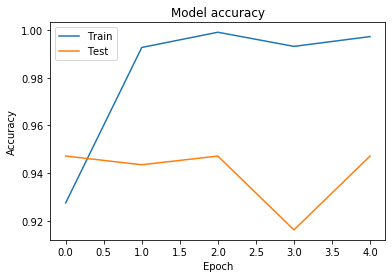

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Predictions

In [ ]:
predictions = model2.predict(encodeText(x_test))
most_likely = predictions.argmax(1)

In [ ]:
index = random.randrange(len(predictions))
print(x_test[index])
print('Prediction: %d, label: %d' % (most_likely[index], y_test[index]))

I really loved the story line and the poler bear was kinda cute.But if anyone has a question about Fort Steele, just ask away:)  
Prediction: 1, label: 1


# Error Analysis

The Veggitarian platter is out of this world!
Prediction: 0, label: 1


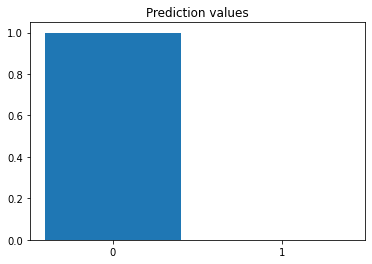

In [ ]:
for i in range(1000):
    index = random.randrange(len(predictions))
    if most_likely[index] != y_test[index]:
        break

print(x_test[index])
print('Prediction: %d, label: %d' % (most_likely[index], y_test[index]))

plt.bar(range(2), predictions[index], tick_label=range(2))
plt.title('Prediction values')
plt.show()

In [ ]:
text = []
labels = []
preds = []
for i in range(len(predictions)):
  if most_likely[i] != y_test[i]:
    text.append(x_test[i])
    labels.append(y_test[i])
    preds.append(most_likely[i])

errors = pd.DataFrame({'Comment':text, 'Sentiment':labels, 'Predictions':preds})
errors.head()

,Comment,Sentiment,Predictions
0,It definitely was not as good as my S11.,1,0
1,For a product that costs as much as this one d...,0,1
2,You get extra minutes so that you can carry ou...,1,0
3,This place deserves one star and 90% has to do...,0,1
4,I'm not really sure how Joey's was voted best ...,0,1
